# Face tracking by using CNNs

In [1]:
from matplotlib import pyplot as plt
from PIL import Image
import csv
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as fun
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import pandas as pd
import os
import cv2
import gc
from torchsummary import summary
import torchvision.transforms as transforms

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"= Using device {device}")
torch.cuda.is_available()

= Using device cuda


True

### 1. DATASET


DATASET from WIDER FACE: A Face Detection Benchmark

link: https://shuoyang1213.me/WIDERFACE/

    1. download WIDER Face Training Images (used for training)
    2. download WIDER Face Validation Images (used for testing since WIDER face test images are not annotated)
    3. download Face Annotations
            -- from this file extract wider_face_train_bbx_gt.txt and wider_face_val_bbx_gt.txt (these txt files contain bounding box of face for each image(left, top, width, height))
    

main directory should look like this:

<img src="directory.png"
     alt="cirectories"
     style="float: left; margin-right: 10px;" />

#### Data for bounding box

In [3]:
# function to create annotation for each image (path of image + bounding box of face)

def create_annotations(path, pres):
    images_info = []
    
    with open(path) as f:
        lines = f.readlines()

    i = 0
    while i < len(lines):
        tmp = lines[i+1]

        if int(tmp)==1: #one person per image
            image_info = []

            image_path = pres + lines[i]    #image name
            bounds = lines[i+2].split(" ")
            x = int(bounds[0])  # x to left
            y = int(bounds[1])  # top
            width = int(bounds[2]) # width of face
            height = int(bounds[3]) # height of face

            image_info.extend([image_path.strip(), x, y, width, height])
            images_info.append(image_info)

            i = i + 3
        else:
            if int(tmp) == 0:
                i = i + 3
            else :   
                i = i + int(tmp) + 2
        
    return images_info

In [4]:
#train dataset annotation
path = "wider_face_train_bbx_gt.txt"
images_info_train = create_annotations(path, "WIDER_train/images/")

In [5]:
#test dataset annotation
path = "wider_face_val_bbx_gt.txt"
images_info_test = create_annotations(path, "WIDER_val/images/")

In [6]:
for i in range(1,12):
    images_info_train.pop(-i)

In [7]:
#number of images in train set
len(images_info_train)

4620

In [8]:
for i in range(1,3):
    images_info_test.pop(-i)

In [9]:
#number of images in test set
len(images_info_test)

1120

EXAMPLE IMAGE IN DATASET
IMAGE INFO: NAME, x, y, width, height : 
['WIDER_val/images/9--Press_Conference/9_Press_Conference_Press_Conference_9_658.jpg', 247, 178, 364, 491]


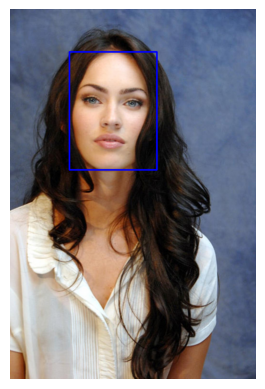

In [10]:
#example image from dataset
#display of image and bounding box around the face
print("EXAMPLE IMAGE IN DATASET")
print("IMAGE INFO: NAME, x, y, width, height : ")
pp = -16
print(images_info_test[pp])


path = images_info_test[pp][0]
img = cv2.imread(path)

x = int(images_info_test[pp][1])
y = int(images_info_test[pp][2])
width = int(images_info_test[pp][3])
height = int(images_info_test[pp][4])
image = cv2.rectangle(img, (x, y),(x+width, y+height) , (255, 0, 0), 5)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


NORMALISED EXAMPLE IMAGE IN DATASET
IMAGE INFO: NAME, x, y, width, height : 
['WIDER_val/images/9--Press_Conference/9_Press_Conference_Press_Conference_9_658.jpg', 247, 178, 364, 491]

mean and std before normalize:
Mean of the image: tensor([0.4340, 0.4178, 0.4367])
Std of the image: tensor([0.2667, 0.2590, 0.2764])


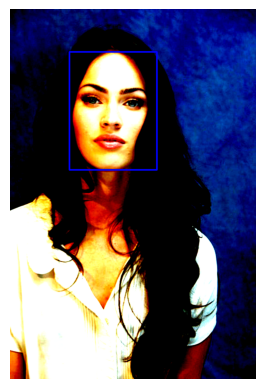

Mean and Std of normalized image:
Mean of the image: tensor([-1.9135e-07, -2.2567e-07,  7.7873e-08])
Std of the image: tensor([1.0000, 1.0000, 1.0000])


In [11]:
print("NORMALISED EXAMPLE IMAGE IN DATASET")
print("IMAGE INFO: NAME, x, y, width, height : ")
pp = -16
print(images_info_test[pp])

path = images_info_test[pp][0]
img = cv2.imread(path)

transform = transforms.Compose([
    transforms.ToTensor()
])
img_tr = transform(img)
mean, std = img_tr.mean([1,2]), img_tr.std([1,2])

# print mean and std
print()
print("mean and std before normalize:")
print("Mean of the image:", mean)
print("Std of the image:", std)

transform_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

img_normalized = transform_norm(img)
 
# convert this image to numpy array
img_normalized = np.array(img_normalized)
 
# transpose from shape of (3,,) to shape of (,,3)
img_normalized = img_normalized.transpose(1, 2, 0).copy() 


x = int(images_info_test[pp][1])
y = int(images_info_test[pp][2])
width = int(images_info_test[pp][3])
height = int(images_info_test[pp][4])
image = cv2.rectangle(img_normalized, (x, y),(x+width, y+height) , (255, 0, 0), 5)
    
# display the normalized image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


# get normalized image
img_nor = transform_norm(img)
 
# cailculate mean and std
mean, std = img_nor.mean([1,2]), img_nor.std([1,2])
 
# print mean and std
print("Mean and Std of normalized image:")
print("Mean of the image:", mean)
print("Std of the image:", std)

FLIPPED EXAMPLE IMAGE IN DATASET
IMAGE INFO: NAME, x, y, width, height : 
['WIDER_val/images/9--Press_Conference/9_Press_Conference_Press_Conference_9_658.jpg', 247, 178, 364, 491]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


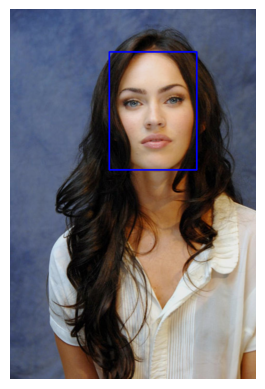

In [12]:
print("FLIPPED EXAMPLE IMAGE IN DATASET")
print("IMAGE INFO: NAME, x, y, width, height : ")
pp = -16
print(images_info_test[pp])

path = images_info_test[pp][0]
img = cv2.imread(path)

transform_inverted = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(1),
    transforms.ColorJitter(brightness=0.2, saturation=0.2, hue=0.2)
])

img_flipped = transform_inverted(img)
 
# convert this image to numpy array
img_flipped = np.array(img_flipped)
 
# transpose from shape of (3,,) to shape of (,,3)
img_flipped = img_flipped.transpose(1, 2, 0).copy() 

width = int(images_info_test[pp][3])
height = int(images_info_test[pp][4])
x = int(img_flipped.shape[1] - images_info_test[pp][1] - width)
y = int(images_info_test[pp][2])
image = cv2.rectangle(img_flipped, (x, y),(x+width, y+height) , (255, 0, 0), 5)
    
# display the normalized image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

#### Images data

In [10]:
train_size = len(images_info_train)
test_size = len(images_info_test)
resize_size = 224

###### Train images dataset

In [14]:
#directory for test dataset
try:
    os.makedirs("train_dataset")
except FileExistsError:
    # directory already exists
    pass

In [11]:
transform = transforms.Compose([
    transforms.ToTensor()
])

transform_inverted = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(1),
    transforms.ColorJitter(brightness=0.2, saturation=0.2, hue=0.2)
])

In [12]:
#creating image train dataset
channels_sum, channels_squared_sum, num_batches = 0, 0, 0

for i in range(0,train_size):

    image_info = images_info_train[i]
    image_path = image_info[0]
    
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    
    x = int(image_info[1])
    y = int(image_info[2])
    width = int(image_info[3])
    height = int(image_info[4])
    
    #rescaling images to 224x224 pixels, variable resize_size = 224
    original_height = img.shape[0]
    original_width = img.shape[1]
    
    images_info_train[i][1] = float(x/(original_width/resize_size))
    images_info_train[i][2] = float(y/(original_height/resize_size))
    images_info_train[i][3] = float(width/(original_width/resize_size))
    images_info_train[i][4] = float(height/(original_height/resize_size))
    
    img = cv2.resize(img, (resize_size, resize_size)) 
    
    #save image to folder train_dataset
    cv2.imwrite("train_dataset"+'\\'+image_path.split("/")[3], img)
    
    img_tr = transform(img)
    
    channels_sum += torch.mean(img_tr, dim=[1,2])
    channels_squared_sum += torch.mean(img_tr**2, dim=[1,2])
    num_batches += 1
    
    #img_flipped = transform_inverted(img)
    
    #width = int(images_info_train[i][3])
    #height = int(images_info_train[i][4])
    #x = int(img_flipped.shape[1] - images_info_train[i][1] - width)
    #y = int(images_info_train[i][2])
    #images_info_train.append([images_info_train[i][0], x, y, width, height])
    
    #channels_sum += torch.mean(img_flipped, dim=[1,2])
    #channels_squared_sum += torch.mean(img_flipped**2, dim=[1,2])
    #num_batches += 1
 
    #img_flipped = np.array(img_flipped)
    #img_flipped = img_flipped.transpose(1, 2, 0).copy()
    
    ##save image to folder train_dataset
    #cv2.imwrite("train_dataset"+'\\inv_'+image_path.split("/")[3], img_flipped)

mean = channels_sum / num_batches
std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5
train_size = len(images_info_train)
print(train_size)

4620


In [13]:
f = open('cvs_train.cvs', 'w')

writer = csv.writer(f)

i = 0

while i < len(images_info_train):
    row = [images_info_train[i][1], images_info_train[i][2], images_info_train[i][3], images_info_train[i][4]]
    writer.writerow(row)
    i = i + 1

f.close()

##### Test images dataset

In [17]:
#directory for test dataset
try:
    os.makedirs("test_dataset")
except FileExistsError:
    # directory already exists
    pass

In [14]:
#creating image test dataset

for i in range(0,test_size):

    image_info = images_info_test[i]
    image_path = image_info[0]
    
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    
    x = int(image_info[1])
    y = int(image_info[2])
    width = int(image_info[3])
    height = int(image_info[4])
    

    #rescaling images to 224x224 pixels, variable resize_size = 224
    original_height = img.shape[0]
    original_width = img.shape[1]
    
    
    images_info_test[i][1] = float(x/(original_width/resize_size))
    images_info_test[i][2] = float(y/(original_height/resize_size))
    images_info_test[i][3] = float(width/(original_width/resize_size))
    images_info_test[i][4] = float(height/(original_height/resize_size))
    
    #cv2.rectangle(img, (x, y), (x + width, y + height), (255, 0, 0), 5)

    img = cv2.resize(img, (resize_size, resize_size)) 
    
    #save image to folder test_dataset
    cv2.imwrite("test_dataset"+'\\'+image_path.split("/")[3], img)


In [37]:
f = open('cvs_test.cvs', 'w')

writer = csv.writer(f)

i = 0

while i < len(images_info_test):
    row = [images_info_test[i][1], images_info_test[i][2], images_info_test[i][3], images_info_test[i][4]]
    writer.writerow(row)
    i = i + 1

f.close()

### MODELS

In [234]:
#starting
class cnn_model(nn.Module):

    def __init__(self):
        
        super(cnn_model, self).__init__()

        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=32,
            kernel_size=5,
            stride=2,
            padding=0
        )

        self.conv2 = nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=5,
            stride=1,
            padding=0
        )

        self.conv3 = nn.Conv2d(
            in_channels=64,
            out_channels=128,
            kernel_size=5,
            stride=1,
            padding=0
        )


        self.fc1 = nn.Linear(
            in_features=25*25*128,
            out_features=2046
        )

        self.fc2 = nn.Linear(
            in_features=2046,
            out_features=4
        )

    def forward(self, val):
        val = fun.relu(self.conv1(val))
        val = fun.max_pool2d(val, kernel_size=2, stride=2)
        val = fun.relu(self.conv2(val))
        val = fun.max_pool2d(val, kernel_size=2, stride=2)
        val = fun.relu(self.conv3(val))
        val = val.view(-1, 25*25*128)
        val = fun.dropout(fun.relu(self.fc1(val)), p=0.5, training=self.training)
        val = self.fc2(val)

        return val

In [236]:
#mlohave sise
class cnn_model(nn.Module):

    def __init__(self):
        
        super(cnn_model, self).__init__()

        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=0
        )
        
        self.conv2 = nn.Conv2d(
            in_channels=32,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=0
        )
        
        self.conv3 = nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=3,
            stride=1,
            padding=0
        )
        
        self.conv4 = nn.Conv2d(
            in_channels=64,
            out_channels=128,
            kernel_size=3,
            stride=1,
            padding=0
        )

        self.conv5 = nn.Conv2d(
            in_channels=128,
            out_channels=128,
            kernel_size=3,
            stride=1,
            padding=0
        )
        
        self.conv6 = nn.Conv2d(
            in_channels=128,
            out_channels=256,
            kernel_size=3,
            stride=1,
            padding=0
        )

        self.fc1 = nn.Linear(
            in_features = 43264,
            out_features=2046
        )

        self.fc2 = nn.Linear(
            in_features=2046,
            out_features=4
        )

    def forward(self, val):
        val = fun.relu(self.conv1(val))
        val = fun.relu(self.conv2(val))
        val = fun.relu(self.conv3(val))
        val = fun.max_pool2d(val, kernel_size=2, stride=2)
        val = fun.dropout(val, p=0.5, training=self.training)
        
        val = fun.relu(self.conv4(val))
        val = fun.max_pool2d(val, kernel_size=2, stride=2)
        val = fun.dropout(val, p=0.5, training=self.training)
        
        val = fun.relu(self.conv5(val))
        val = fun.max_pool2d(val, kernel_size=2, stride=2)
        val = fun.dropout(val, p=0.5, training=self.training)
       
        val = fun.relu(self.conv6(val))
        val = fun.max_pool2d(val, kernel_size=2, stride=2)
        val = fun.dropout(val, p=0.5, training=self.training)

        val = torch.flatten(val, 1)
        val = fun.dropout(fun.relu(self.fc1(val)), p=0.5, training=self.training)
        val = self.fc2(val)

        return val

In [241]:
#AlexNet
class cnn_model(nn.Module):

    def __init__(self):
        
        super(cnn_model, self).__init__()

        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=96,
            kernel_size=11,
            stride=4,
            padding=0
        )

        self.conv2 = nn.Conv2d(
            in_channels=96,
            out_channels=256,
            kernel_size=5,
            stride=1,
            padding=2
        )

        self.conv3 = nn.Conv2d(
            in_channels=256,
            out_channels=384,
            kernel_size=3,
            stride=1,
            padding=1
        )
        
        self.conv4 = nn.Conv2d(
            in_channels=384,
            out_channels=384,
            kernel_size=3,
            stride=1,
            padding=1
        )
        
        self.conv5 = nn.Conv2d(
            in_channels=384,
            out_channels=256,
            kernel_size=3,
            stride=1,
            padding=1
        )

        self.fc1 = nn.Linear(
            in_features=6*6*256,
            out_features=4096
        )
        
        self.fc2 = nn.Linear(
            in_features=4096,
            out_features=1024
        )

        self.fc3 = nn.Linear(
            in_features=1024,
            out_features=4
        )

    def forward(self, val):
        val = fun.relu(self.conv1(val))
        val = fun.max_pool2d(val, kernel_size=3, stride=2)
        val = fun.relu(self.conv2(val))
        val = fun.max_pool2d(val, kernel_size=3, stride=2)
        val = fun.relu(self.conv3(val))
        val = fun.relu(self.conv4(val))
        val = fun.relu(self.conv5(val))
        val = fun.max_pool2d(val, kernel_size=3, stride=2)
        val = val.view(-1, 6*6*256)
        val = fun.dropout(fun.relu(self.fc1(val)), p=0.5, training=self.training)
        val = fun.dropout(fun.relu(self.fc2(val)), p=0.5, training=self.training)
        val = self.fc3(val)

        return val

In [29]:
class conv_block(nn.Module):
    
    def __init__(self, in_channels, out_channels, **kwargs):
        
        super(conv_block, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        
    def forward(self, val):
        return fun.relu(self.batchnorm(self.conv(val)))
        

class Inception_block(nn.Module):
    
    def __init__(self, in_channels, out1x1, red3x3, out3x3, red5x5, out5x5, out1x1pool):
        
        super(Inception_block, self).__init__()
        
        self.branch1 = conv_block(in_channels, out1x1, kernel_size=1)
        
        self.branch2 = nn.Sequential(
            conv_block(in_channels, red3x3, kernel_size=1),
            conv_block(red3x3, out3x3, kernel_size=3, padding=1)
        )
        
        self.branch3 = nn.Sequential(
            conv_block(in_channels, red5x5, kernel_size=1),
            conv_block(red5x5, out5x5, kernel_size=5, padding=2)
        )
        
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            conv_block(in_channels, out1x1pool, kernel_size=1)
        )
        
        
    def forward(self, val):
        return torch.cat([self.branch1(val), self.branch2(val), self.branch3(val), self.branch4(val)], 1)

        
#GoogLeNet
class cnn_model(nn.Module):

    def __init__(self):
        
        super(cnn_model, self).__init__()

        self.conv1 = conv_block(
            in_channels=3,
            out_channels=64,
            kernel_size=7,
            stride=2,
            padding=3
        )

        self.conv2 = conv_block(
            in_channels=64,
            out_channels=192,
            kernel_size=3,
            stride=1,
            padding=1
        )

        self.inception3a = Inception_block(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception_block(256, 128, 128, 192, 32, 96, 64)
        
        self.inception4a = Inception_block(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception_block(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception_block(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception_block(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception_block(528, 256, 160, 320, 32, 128, 128)
        
        self.inception5a = Inception_block(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception_block(832, 384, 192, 384, 48, 128, 128)
        
        self.fc1 = nn.Linear(
            in_features=1024,
            out_features=4
        )
        

    def forward(self, val):
        val = fun.relu(self.conv1(val))
        val = fun.max_pool2d(val, kernel_size=3, stride=2)
        val = fun.relu(self.conv2(val))
        val = fun.max_pool2d(val, kernel_size=3, stride=2)
        
        val = self.inception3a(val)
        val = self.inception3b(val)
        val = fun.max_pool2d(val, kernel_size=3, stride=2)
        
        val = self.inception4a(val)
        val = self.inception4b(val)
        val = self.inception4c(val)
        val = self.inception4d(val)
        val = self.inception4e(val)
        val = fun.max_pool2d(val, kernel_size=3, stride=2)

        val = self.inception5a(val)
        val = self.inception5b(val)
        val = fun.avg_pool2d(val, kernel_size=6, stride=1)
        
        val = val.reshape(val.shape[0], -1)
        val = fun.dropout(val, p=0.4, training=self.training)
        val = self.fc1(val)
        
        return val

In [30]:
model = cnn_model().to(device)

In [243]:
summary(model1, (3, 256, 256)) #starting
summary(model2, (3, 256, 256)) #mlohave sise
summary(model3, (3, 256, 256)) #AlexNet
summary(model4, (3, 256, 256)) #GoogLeNet
print()

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 126, 126]        2,432
├─Conv2d: 1-2                            [-1, 64, 59, 59]          51,264
├─Conv2d: 1-3                            [-1, 128, 25, 25]         204,928
├─Linear: 1-4                            [-1, 2046]                163,682,046
├─Linear: 1-5                            [-1, 4]                   8,188
Total params: 163,948,858
Trainable params: 163,948,858
Non-trainable params: 0
Total mult-adds (M): 508.02
Input size (MB): 0.75
Forward/backward pass size (MB): 6.20
Params size (MB): 625.42
Estimated Total Size (MB): 632.37
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 254, 254]        896
├─Conv2d: 1-2                            [-1, 32, 252, 252]        9,248
├─Conv2d: 1-3                            [-1, 64, 250, 250]        18,496
├─Conv2d: 1-4                  

In [17]:
transform_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [33]:
i = 0

test_images_l = []

while i < len(images_info_test):
    img = cv2.imread("./test_dataset/"+images_info_test[i][0].split("/")[3], cv2.IMREAD_COLOR)
    img_normalized = transform_norm(img)
    arr = np.array(img_normalized)
    arr = arr.transpose(1, 2, 0).copy() 
    arr = arr.ravel()
    test_images_l.append(arr.tolist())
    i = i + 1

In [38]:
len(test_images_l)

1120

In [18]:
i = 0

train_images_l = []

while i < train_size: #/2
    img = cv2.imread("./train_dataset/"+images_info_train[i][0].split("/")[3], cv2.IMREAD_COLOR)
    img_normalized = transform_norm(img)
    arr = np.array(img_normalized)
    arr = arr.transpose(1, 2, 0).copy()
    arr = arr.ravel()
    train_images_l.append(arr.tolist())
    i = i + 1

In [16]:
len(train_images_l)

4620

In [19]:
#no work, dont run

while i < 8000:        
    img = cv2.imread("./train_dataset/inv_"+images_info_train[i][0].split("/")[3], cv2.IMREAD_COLOR)
    img_normalized = transform_norm(img)
    arr = np.array(img_normalized)
    arr = arr.transpose(1, 2, 0).copy()
    arr = arr.ravel()
    train_images_l.append(arr.tolist())
    i = i + 1

In [21]:
#no work, dont run

f = open('train_images_l.cvs', 'w')

writer = csv.writer(f)

i = 0

while i < len(train_images_l):
    row = train_images_l[0]
    writer.writerow(row)
    i = i + 1

f.close()

In [61]:
def evaluate(net, test_loader, criterion, size, device, err=10):
    net.eval()
    
    test_loss = 0
    acc = 0
    id = torch.tensor([True, True, True, True], device=device)
    
    #rands = np.random.randint(test_size, size=size)
    for i, data in enumerate(test_loader):
        inputs, _ = data
        inputs = inputs.view(1, 3, 224, 224).to(device)

        outputs = torch.squeeze(net(inputs))
        labels = torch.Tensor(np.array(images_info_test[i][1:])).to(device)

        temp_loss = criterion(outputs, labels)
        
        correct = (temp_loss<=err).eq(id).sum().item()/4
        
        acc = acc + correct
        #test_loss = test_loss + temp_loss
        
        del inputs, outputs, labels
     
    return acc*100/size
    #return test_loss/size

In [67]:
def train_model(net, train_loader, test_loader, batchSize, epochs, lr_rate, momentum, device):
    prev_loss=0
    criterion = nn.MSELoss()
    criterion2 = nn.L1Loss(size_average=False, reduce=False, reduction='none')
    optimization = optim.SGD(net.parameters(), lr=lr_rate, momentum=momentum)
    scheduler = optim.lr_scheduler.StepLR(optimization, step_size=30, gamma=0.1)

    for epoch in range(epochs):
        net.train()
        
        loss_avg = 0
        
        for i, data in enumerate(train_loader):
            optimization.zero_grad()

            inputs, labels = data
            inputs, labels = inputs.view(batchSize, 3, 224, 224).to(device), labels.view(batchSize, 4).to(device)

            outputs = net(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimization.step()
            
            del inputs, outputs, labels
            
            loss_avg = loss_avg + loss.item()
        
        scheduler.step()
        train_loss=loss_avg/batchSize
        print("epoch " + str(epoch+1) + ".  loss: " + str(train_loss))
        
        #ako CUDA memorija zapne, smanji size
        test_loss = evaluate(net, test_loader, criterion2, test_size, device)
        
        print("     avg test acc for this epoch: " + str(test_loss) + "%")
        if abs(train_loss-prev_loss)<0.1:
            break
        prev_loss=train_loss
        
        if test_loss > 80:
            torch.save(model.state_dict(), './model-saved' + str(epoch+1) + '.pth')
            break


In [36]:
class training_dataset(Dataset):
    
    def __init__(self, images, csv):
        trainX = np.asarray(images)
        #trainX = np.asarray(pd.read_csv('train_images_l.cvs', sep=',', header=None))
        self.len = len(trainX)
        
        trainY = np.asarray(pd.read_csv(csv, sep=',', header=None))
        
        self.features_train = torch.Tensor(trainX)
        self.groundTruth_train = torch.Tensor(trainY)

    def __getitem__(self, item):
        return self.features_train[item], self.groundTruth_train[item]

    def __len__(self):
        return self.len

In [22]:
ts = training_dataset(train_images_l, 'cvs_train.cvs')

In [39]:
test_ds = training_dataset(test_images_l, 'cvs_test.cvs')

In [110]:
learning_rate = 0.00001
momentum = 0.9
batch = 20
no_of_workers = 0
shuffle = True
epochs = 20

train_loader = DataLoader(
        dataset=ts,
        batch_size=batch,
        shuffle=shuffle,
        pin_memory=True,
        num_workers=no_of_workers)

test_loader = DataLoader(
        dataset=test_ds,
        batch_size=1,
        shuffle=False,
        pin_memory=True,
        num_workers=no_of_workers)

In [140]:
train_model(model, train_loader, test_loader, batch, epochs, learning_rate, momentum, device)

epoch 1.  loss: 356.9772575378418
     avg test acc for this epoch: 41.183035714285715%
epoch 2.  loss: 377.5184414386749
     avg test acc for this epoch: 42.410714285714285%
epoch 3.  loss: 328.64523820877076
     avg test acc for this epoch: 41.941964285714285%
epoch 4.  loss: 344.6244470119476
     avg test acc for this epoch: 41.785714285714285%
epoch 5.  loss: 374.5150740146637
     avg test acc for this epoch: 41.71875%
epoch 6.  loss: 358.60616931915285
     avg test acc for this epoch: 42.32142857142857%
epoch 7.  loss: 346.94019780159
     avg test acc for this epoch: 41.22767857142857%
epoch 8.  loss: 375.0462695598602
     avg test acc for this epoch: 41.049107142857146%
epoch 9.  loss: 365.76854372024536
     avg test acc for this epoch: 40.9375%
epoch 10.  loss: 337.95318207740786
     avg test acc for this epoch: 41.495535714285715%
epoch 11.  loss: 329.90009317398074
     avg test acc for this epoch: 41.361607142857146%
epoch 12.  loss: 334.8781617641449
     avg test a

In [74]:
torch.cuda.memory_allocated()

123566592

In [141]:
torch.save(model.state_dict(), './model_google.pth')

In [102]:
#run after every training to clear access memory
gc.collect()
torch.cuda.empty_cache()

###### example test for images in test dataset

In [103]:
def test_image(index):
    
    img = cv2.imread("./test_dataset/"+images_info_test[index][0].split("/")[3], cv2.IMREAD_COLOR) 
    image_true = cv2.rectangle(img, (int(images_info_test[index][1]), int(images_info_test[index][2])),(int(images_info_test[index][3]) + 
                                                                               int(images_info_test[index][1]),
                                              int(images_info_test[index][4]) + int(images_info_test[index][2])) , (255, 0, 0), 1)
    #image_true = cv2.resize(image, (600, 800))
    
    inputs = np.array(transform_norm(img))
    inputs = inputs.transpose(1, 2, 0).copy()
    inputs = torch.Tensor(inputs.ravel())
    inputs = inputs.view(1, 3, 224, 224)
    predict = torch.squeeze(model(inputs.to(device)).detach().cpu()).tolist()
    
    print("true value of bounding box:")
    print(images_info_test[index][1:])
    print()
    print("predicted value of bounding box:")
    print(predict)
    
    img = cv2.imread("./test_dataset/"+images_info_test[index][0].split("/")[3], cv2.IMREAD_COLOR) 
    image_pred = cv2.rectangle(img, (int(predict[0]), int(predict[1])),(int(predict[2]) + 
                                                                               int(predict[0]),
                                              int(predict[3]) + int(predict[1])) , (255, 0, 0), 1)
    #image_pred = cv2.resize(image_pred, (600, 800))
    
    plt.subplot(1, 2, 1)

    plt.imshow(cv2.cvtColor(image_true, cv2.COLOR_BGR2RGB))
    plt.title("true")
    plt.axis('off')
    plt.show()

    plt.subplot(1, 2, 2)

    plt.imshow(cv2.cvtColor(image_pred, cv2.COLOR_BGR2RGB))
    plt.title("predicted")
    plt.axis('off')
    plt.show()

0. Image

true value of bounding box:
[109.59375, 26.256410256410255, 62.34375, 72.6974358974359]

predicted value of bounding box:
[109.00871276855469, 35.45079040527344, 29.334943771362305, 47.065547943115234]


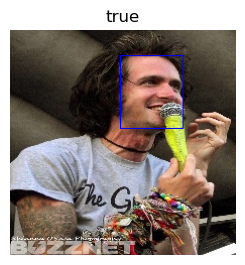

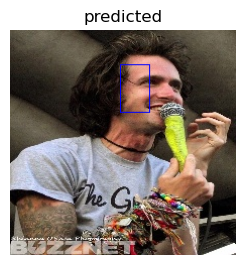

2. Image

true value of bounding box:
[140.65625, 49.0, 70.875, 80.64583333333334]

predicted value of bounding box:
[101.83443450927734, 48.956634521484375, 40.36194610595703, 37.678794860839844]


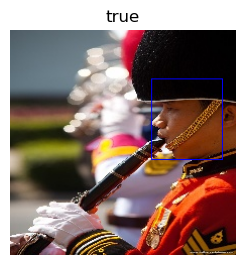

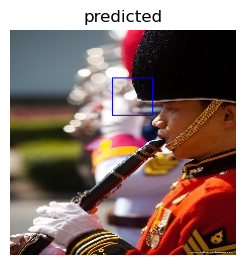

In [ ]:
#test for images in test dataset
pics = [0, 2, 4, 1104]
model.load_state_dict(torch.load('./model_google.pth'))
model.eval()

for i in pics:
    print(str(i) + ". Image")
    print()
    test_image(i)

In [134]:
model.load_state_dict(torch.load('./model_google.pth'))
criterion2 = nn.L1Loss(size_average=False, reduce=False, reduction='none')
test_loss_google = evaluate(model, test_loader, criterion2, test_size, device, 15)

In [135]:
#print("avg test acc for starting model: " + str(test_loss_starting) + "%")
#print("avg test acc for mlohave sise model: " + str(test_loss_mlohave) + "%")
#print("avg test acc for AlexNet model: " + str(test_loss_alex) + "%")
print("avg test acc for GoogLeNet model: " + str(test_loss_google) + "%")

avg test acc for GoogLeNet model: 55.357142857142854%
